In [1]:
import pandas as pd
import numpy as np
import math
import re
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from scipy import interp

data_folder = '../../data/csv_data/'
extension = '.csv.gz'
build_path = lambda x: data_folder + x + extension

In [2]:
big_dataset = pd.read_csv(build_path('all_samples')).set_index('link')
file_info = pd.read_csv(build_path('malwr_file_info_filtered')).set_index('link')
big_dataset = big_dataset.join(file_info.start_time, how='left').dropna(subset=['start_time']).sort_values('start_time')

In [3]:
loose_data = pd.read_csv(build_path('loose_dataset')).set_index('link').index
big_dataset = big_dataset.loc[big_dataset.index.isin(loose_data), :]

In [4]:
malware_labeled = pd.read_csv(build_path('malware_labeled')).set_index('link')
malware_labeled = malware_labeled.astype(float)

In [5]:
mal_classes = list(malware_labeled.columns)

datasets = dict()
for mclass in mal_classes:
    mal = malware_labeled[mclass].dropna()
    datasets[mclass] = mal.index
    
mal_classes += ['goodware']
datasets['goodware'] = big_dataset[big_dataset.malware == False].index

In [6]:
# Split dataset into fixed test and training
split_position = len(big_dataset) - int(len(big_dataset) * 0.2)
training_set = big_dataset[:split_position].sort_values('start_time', ascending=False).drop('start_time', axis=1)
test_set = big_dataset[split_position:].drop('start_time', axis=1)

In [7]:
# Split into 10 training folds
train_size = int(len(training_set) / 10)

'Fold 0; Goodware/Malware ratio: 0.01'

'Fold 1; Goodware/Malware ratio: 0.01'

'Fold 2; Goodware/Malware ratio: 0.02'

'Fold 3; Goodware/Malware ratio: 0.02'

'Fold 4; Goodware/Malware ratio: 0.02'

'Fold 5; Goodware/Malware ratio: 0.01'

'Fold 6; Goodware/Malware ratio: 0.01'

'Fold 7; Goodware/Malware ratio: 0.01'

'Fold 8; Goodware/Malware ratio: 0.01'

'Fold 9; Goodware/Malware ratio: 0.02'

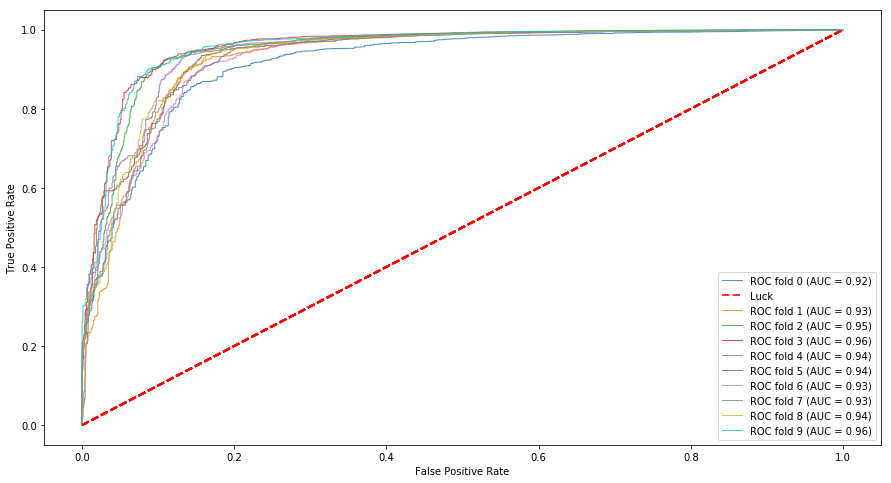

In [8]:
plt.figure(figsize=(15, 8))
tprs = []
aucs = []
auc_frame = []
mean_fpr = np.linspace(0, 1, 100)

x_test = test_set.drop('malware', axis=1)
y_test = test_set.malware
for i in range(10):
    fold_size = i*train_size + train_size
    x_training = training_set[:fold_size].drop('malware', axis=1)
    y_training = training_set[:fold_size].malware
    
    nmalware = len(y_training[y_training == True])
    ngoodware = len(y_training[y_training == False])
    display('Fold {}; Goodware/Malware ratio: {:.2f}'.format(i, ngoodware/nmalware))
    
    # Train every subclassifier
    sub_classifiers = dict()
    cls_tasks = []
    for mclass in mal_classes:
        # Generate training samples
        x_sub_training = x_training
        y_sub_training = y_training.copy()
        y_sub_training[y_sub_training.index.isin(datasets[mclass])] = True
        y_sub_training[~y_sub_training.index.isin(datasets[mclass])] = False
        sub_classifiers[mclass] = LogisticRegression().fit(x_sub_training, y_sub_training)
        
    # Predict probabilities for the training
    x_big_training = np.array([cls.predict_proba(x_training)[:, 1] for cls in sub_classifiers.values()]).transpose()
    # Predict probabilities for the test
    x_big_test = np.array([cls.predict_proba(x_test)[:, 1] for cls in sub_classifiers.values()]).transpose()
    # Train and test general classifier
    final_classifier = LogisticRegression().fit(x_big_training, y_training)
    probas_ = final_classifier.predict_proba(x_big_test)
    
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.8,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Luck', alpha=.8)
    
auc_frame.append(aucs)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)    

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()